# Lab Setup
The lab setup ses the following topology.
![](figs/Picture3.jpg)

# Preparing MongoDB Server

## Install MongoDB on Ubuntu Server

Run the following script to install MongoDB

```
sudo apt-get install gnupg
wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo apt-key add -
echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
sudo apt -y update
sudo apt -y install -y mongodb-org
echo "mongodb-org hold" | sudo dpkg --set-selections
echo "mongodb-org-database hold" | sudo dpkg --set-selections
echo "mongodb-org-server hold" | sudo dpkg --set-selections
echo "mongodb-mongosh hold" | sudo dpkg --set-selections
echo "mongodb-org-mongos hold" | sudo dpkg --set-selections
echo "mongodb-org-tools hold" | sudo dpkg --set-selections
sudo systemctl start mongod
sudo systemctl enable mongod
sudo systemctl status mongod
```

You should see the following status message...

```
● mongod.service - MongoDB Database Server
     Loaded: loaded (/lib/systemd/system/mongod.service; enabled; vendor preset: enabled)
     Active: active (running) since Mon 2023-02-27 17:01:37 UTC; 3h 30min ago
       Docs: https://docs.mongodb.org/manual
   Main PID: 1576 (mongod)
     Memory: 285.4M
        CPU: 2min 48.909s
     CGroup: /system.slice/mongod.service
             └─1576 /usr/bin/mongod --config /etc/mongod.conf

Feb 27 17:01:37 mongodb-serer systemd[1]: Started MongoDB Database Server.
```

## Allow external access to the MongoDB server

1. Open the mongodb config file: `/etc/mongod.conf`
2. Update the binding IP: `bindIp: 0.0.0.0`
3. Restart MongoDB services: `sudo systemctl restart mongod.service`

## Test external GUI access

1. Install MongoDB Atlas GUI on the host computer.
2. Open Atlas and setup a connection string with the host computer's IP.<br>
![](figs/Picture1.png)

# Configuring Matlab 

## Base Setup
1. Install Matlab version __2022a__ (Specific version for MongoDB support).
2. Install the following add-ons
    1. Database Toolbox
    2. Database Toolbox Interface for MongoDB


## convert the SLX file to MDL 
Matlab 2022a does not support the SLX file, convert the file to specific version (2022a) i.e., MDL format.

## Simulation 
1. Open the simulation and run it for $n$ seconds. <br>
   ![](figs/Picture2.png)
2. At the end of the simulation, it creates an `out` variables on the MATLAB workspace.

## MongoDB Integration
1. Run the following code to read from the `out` variable, format and insert into the Mongo backend.
2. Data format:
    ```
    {
        t_stamp : float,
        current: {
            ia: float,
            ib: float,
            ic: float
        },
        voltage:{
            va: float,
            vb: float,
            vc: float
        }
    }
    ```
### Integration Script

```
import database.mongo.*;


%% database params
host='192.168.200.129';       % IP of the MongoDB server
port=27017;                   % default port number 
db='ps_link';                 % name of the databse to populate 
collection='test_collection_2'; % name of the collection (device ID)

%% Connection Establishment 
conn = mongoc(host, port, db);  

if conn.isopen() == 1
    disp('Connection is active...');
else
    disp(strcat('Failed to connect',host,':',port,'/',db))
end

%% operate 
samples_size = length(out.Current);
%createCollection(conn, collection)

% segrigating variables
object_counter=0;
for i = 1:samples_size
    t_stamp = out.tout(i);

    i_a = out.Current(i,1);  %current from phase A
    i_b = out.Current(i,2);  %current from phase B
    i_c = out.Current(i,3);  %current from phase C

    v_a = out.Current(i,1);  %voltage from phase A
    v_b = out.Current(i,2);  %voltage from phase B
    v_c = out.Current(i,3);  %voltage from phase C

    % format string 
    fmt_str='{"t_stamp":%d, "current":{"phase_a": %f, "phase_b": %f, "phase_c": %f},"voltage":{"phase_a": %f, "phase_b": %f, "phase_c": %f}}';
    object = sprintf(fmt_str, t_stamp, i_a, i_b, i_c, v_a, v_b, v_c);
    object_counter=object_counter+1;
    
    %insert into MongoDB
    insert(conn,collection,object);

    disp(fprintf("%d / %d",object_counter, samples_size));
end
disp(object_counter, 'samples inserted...')
%% Connection Termination
conn.close()
disp('Connection closed')
```

# Reading from Python 

The following code reads from the mongodb server and plots the inserted values.

Connection successful...
fetching data...


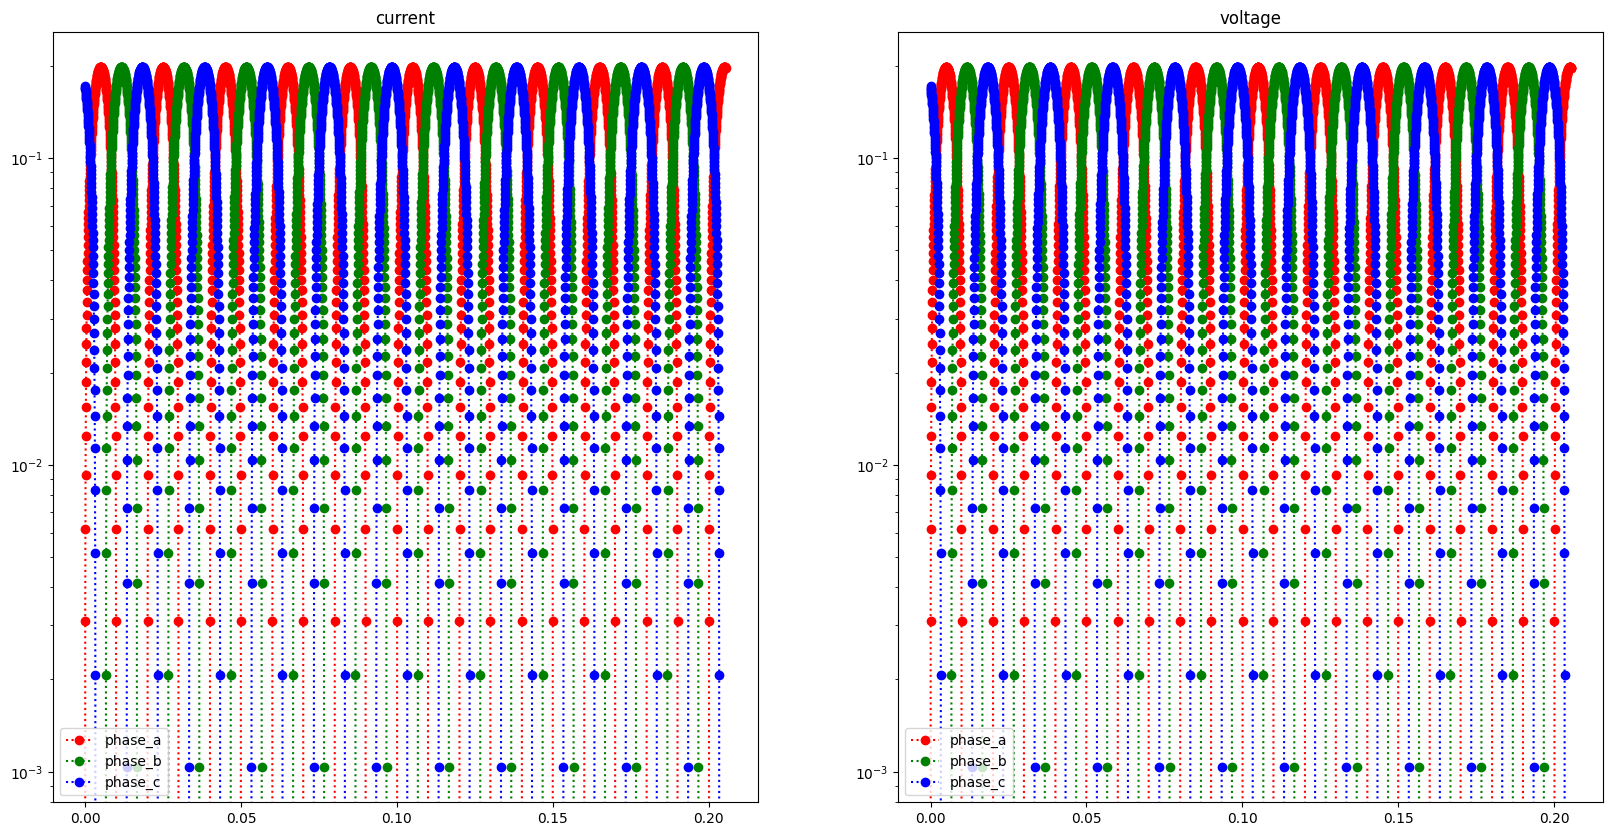

In [4]:
''''
This code reads data from a remote mongoDB server and plots graph 
'''
import pymongo 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

def main():
    db_vars ={
        'hostname':'192.168.200.129',
        'port':27017,
        'db':'ps_link',
        'collection':'test_collection_1'
    }

    conn_str = f"mongodb://{db_vars['hostname']}:{db_vars['port']}/"
    client = pymongo.MongoClient(conn_str, serverSelectionTimeoutMS=5000)
    db = client[db_vars['db']]
    collection=db[db_vars['collection']]
    query={}

    db_info = client.server_info()
    print('Connection successful...')

    print('fetching data...')
    result = [ item for item in  collection.find() ]
    
    ### Plotting
    nrow=1
    ncol=2

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol)

    t_stamp = [i['t_stamp'] for i in result]
    phase_color_map={
        'phase_a':'r',
        'phase_b':'g',
        'phase_c':'b'
    }
    index=0
    for attr in ['current', 'voltage']:
        for phase in ['phase_a','phase_b', 'phase_c']:
            magnitude = [i[attr][phase] for i in result]
            color=phase_color_map[phase]
            ax[index].plot(t_stamp, magnitude, f'{color}o:', label=phase)
        ax[index].set_title(attr)
        ax[index].set_yscale('log')
        ax[index].legend()
        index+=1
                        
    plt.show()

if __name__ == '__main__':
    main()